# Main ERP Pipeline

This notebook contains processing steps for BCI III P300 dataset.
The goal is to classify ERP forms for target and common stimuli using peak features

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [3]:
from load import load_bci_iii_data as load_data

In [4]:
from preprocess import process_signal, restore_raw, get_events

In [5]:
import pandas as pd

In [6]:
import matplotlib.pyplot as plt

# Load and preprocess data

You can find the description of each method in the related src/*.py file

In [9]:
good_subject = "Subject_A_Train"

In [10]:
sessions_df, true_characters = load_data(good_subject)

Creating RawArray with float64 data, n_channels=65, n_times=662490
    Range : 0 ... 662489 =      0.000 ...  2760.371 secs
Ready.
The unit for channel(s) Af3, Af4, Af7, Af8, Afz, C1, C2, C3, C4, C5, C6, Cp1, Cp2, Cp3, Cp4, Cp5, Cp6, Cpz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, Fc1, Fc2, Fc3, Fc4, Fc5, Fc6, Fcz, Fp1, Fp2, Fpz, Ft7, Ft8, Fz, Iz, O1, O2, Oz, P1, P2, P3, P4, P5, P6, P7, P8, Po3, Po4, Po7, Po8, Poz, Pz, T10, T7, T8, T9, Tp7, Tp8 has changed from NA to V.
15300 events found
Event IDs: [1 2]


../src/preprocess.py:24: RuntimeWarning: The unit for channel(s) Af3, Af4, Af7, Af8, Afz, C1, C2, C3, C4, C5, C6, Cp1, Cp2, Cp3, Cp4, Cp5, Cp6, Cpz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, Fc1, Fc2, Fc3, Fc4, Fc5, Fc6, Fcz, Fp1, Fp2, Fpz, Ft7, Ft8, Fz, Iz, O1, O2, Oz, P1, P2, P3, P4, P5, P6, P7, P8, Po3, Po4, Po7, Po8, Poz, Pz, T10, T7, T8, T9, Tp7, Tp8 has changed from NA to V.
  raw.set_channel_types(channel_types)


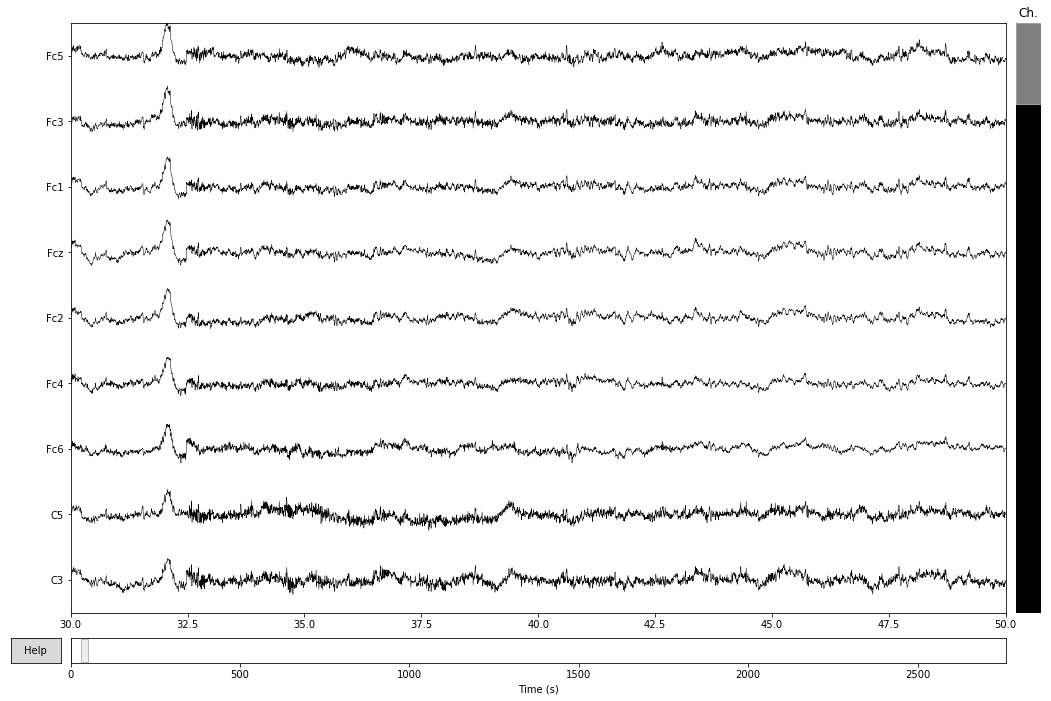

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1585 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 10 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 2.5 Hz
Filter length of 1585 samples (6.604 sec) selected


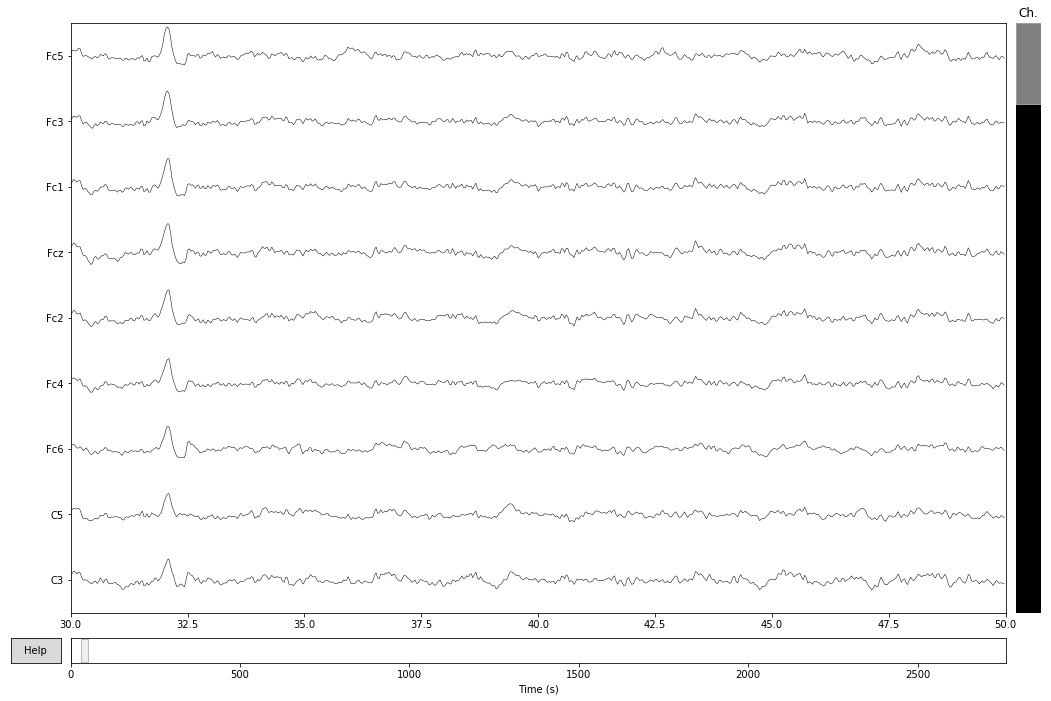

8612 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 8612 events and 193 original time points ...
1 bad epochs dropped
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


../src/visualize.py:31: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['1'].average().plot(units=units)


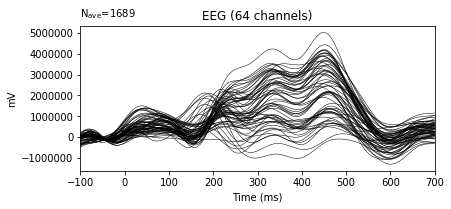

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


../src/visualize.py:34: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['2'].average().plot(units=units)


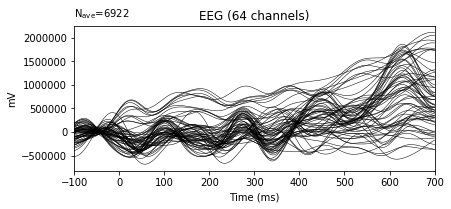

In [11]:
epochs = process_signal(sessions_df)

In [16]:
epochs

<Epochs  |   8611 events (all good), -0.1 - 0.7 sec, baseline [None, 0], ~811.6 MB, data loaded,
 '1': 1689
 '2': 6922>

# Train model

In [62]:
from models import P300ClassifierLDA, P300ClassifierSVM, get_dataset

In [63]:
import numpy as np

In [64]:
from sklearn.model_selection import GridSearchCV, train_test_split

In [65]:
from sklearn.svm import SVC

In [66]:
from sklearn.ensemble import BaggingClassifier

In [67]:
from sklearn.metrics import confusion_matrix

In [68]:
n_estimators = 17

In [69]:
simple_model = SVC(gamma='auto', kernel="linear", cache_size=2000)

In [70]:
model = BaggingClassifier(
    simple_model, 
    bootstrap=False, 
    n_estimators=n_estimators, 
    max_samples=len(epochs) // n_estimators,
    n_jobs=8
)

In [100]:
grid = {
    "base_estimator__C": np.logspace(-1, 1, 20)
}

In [101]:
search = GridSearchCV(model, grid, cv=5, scoring="roc_auc", n_jobs=4)

In [102]:
X, y = get_dataset(epochs.copy())

In [103]:
X.shape

(8611, 1600)

In [104]:
# Replace with time series split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3)

In [105]:
search.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=BaggingClassifier(base_estimator=SVC(C=1.0, cache_size=2000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
         bootstrap=False, bootstrap_features=False, max_features=1.0,
         max_samples=506, n_estimators=17, n_jobs=8, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'base_estimator__C': array([ 0.1    ,  0.12743,  0.16238,  0.20691,  0.26367,  0.33598,
        0.42813,  0.54556,  0.69519,  0.88587,  1.12884,  1.43845,
        1.83298,  2.33572,  2.97635,  3.79269,  4.83293,  6.15848,
        7.8476 , 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [106]:
search.best_estimator_

BaggingClassifier(base_estimator=SVC(C=1.8329807108324356, cache_size=2000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
         bootstrap=False, bootstrap_features=False, max_features=1.0,
         max_samples=506, n_estimators=17, n_jobs=8, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [107]:
search.best_score_

0.776587357009061

In [108]:
prediction = search.predict(test_X)

In [146]:
confusion_matrix(test_y, prediction)

array([[2019,   68],
       [ 378,  119]])

In [ ]:
signal 240 Hz

lowpass 30 Hz ()
highpass 0.5 Hz

resample 20 Hz

In [ ]:
'The measurement information indicates a low-pass frequency '
 'of %g Hz. The decim=%i parameter will result in a sampling '
 'frequency of %g Hz, which can cause aliasing artifacts.'

In [161]:
667 * 30 / 1000

6.67

13.34

In [159]:
667 * 240 / 1000

160.08

In [160]:
160 * 64

10240

- Add ERP filtering

# Multiclass averaging TODO

In [110]:
from sklearn.metrics import accuracy_score

In [111]:
character_matrix = """
ABCDEF
GHIJKL
MNOPQR
STUVWX
WZ1234
56789_
""".strip().split("\n")

In [112]:
assert character_matrix[0][5] == 'F'

In [113]:
indices = epochs.events.T[0]

In [114]:
events_start_df = sessions_df[["InputIndex", "Code"]].loc[indices].copy()

In [115]:
events_start_df["EventIndex"] = range(events_start_df.shape[0])

In [116]:
def select_epochs_in_interval(input_index, row_column):
    global epochs, events_start_df
    selected_indices = events_start_df[
        (events_start_df["InputIndex"] == input_index) & \
        (events_start_df["Code"] == row_column)
    ]["EventIndex"]
    return epochs[selected_indices]

In [117]:
from tqdm import tqdm_notebook

In [118]:
predicted_characters = []

for trial, true_character in enumerate(tqdm_notebook(true_characters)):
    row_predictions = []
    column_predictions = []
    
    for row_column in range(1, 13):
        trials_row_column = select_epochs_in_interval(trial, row_column)
        trials_X, _ = get_dataset(trials_row_column)
        
        trial_scores = []
        for estimator in search.best_estimator_.estimators_:
            score = estimator.decision_function(trials_X)
            trial_scores += [score]

        trial_prediction = np.mean(trial_scores)
    
        if row_column < 7:
            column_predictions.append(trial_prediction)
        else:
            row_predictions.append(trial_prediction)
        
    row = np.argmax(row_predictions)
    column = np.argmax(column_predictions)
    predicted_characters.append(character_matrix[row][column])

In [132]:
import seaborn as sns

In [134]:
multiclass_matrix = confusion_matrix([c for c in true_characters], predicted_characters)

In [122]:
accuracy_score([c for c in true_characters], predicted_characters)

0.8588235294117647

In [102]:
# for i in search.best_estimator_.estimators_samples_[1]:
#     assert i in search.best_estimator_.estimators_samples_[0], i 

In [143]:
counts = {}

for c in true_characters:
    if c not in counts:
        counts[c] = 0
        
    counts[c] += 1

In [145]:
counts

{'E': 8,
 'A': 2,
 'V': 2,
 'Q': 3,
 'T': 4,
 'D': 4,
 'O': 9,
 'J': 2,
 'G': 2,
 '8': 1,
 'R': 5,
 'B': 3,
 'N': 2,
 'C': 3,
 'H': 4,
 'U': 5,
 'I': 3,
 'P': 2,
 'M': 2,
 '6': 1,
 'X': 2,
 'F': 2,
 'K': 3,
 'W': 3,
 '4': 1,
 'Z': 2,
 'L': 2,
 'Y': 2,
 '_': 1}

In [148]:
119 / (119 + 68)

0.6363636363636364

In [147]:
119 / (119 + 378)

0.23943661971830985

In [150]:
test_y.sum()

497

In [ ]:
[2019,   68]
[ 378,  119]

In [152]:
test_y

array([1, 0, 0, ..., 1, 0, 0])

In [ ]:
[]

In [154]:
confusion_matrix(
    y_true=[0, 1, 0, 1, 1], 
    y_pred=[0, 1, 1, 0, 1]
)

array([[1, 1],
       [1, 2]])

In [151]:
help(confusion_matrix)

Help on function confusion_matrix in module sklearn.metrics.classification:

confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)
    Compute confusion matrix to evaluate the accuracy of a classification
    
    By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
    is equal to the number of observations known to be in group :math:`i` but
    predicted to be in group :math:`j`.
    
    Thus in binary classification, the count of true negatives is
    :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
    :math:`C_{1,1}` and false positives is :math:`C_{0,1}`.
    
    Read more in the :ref:`User Guide <confusion_matrix>`.
    
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (correct) target values.
    
    y_pred : array, shape = [n_samples]
        Estimated targets as returned by a classifier.
    
    labels : array, shape = [n_classes], optional
        List of labels to index the m

In [158]:
test_y.sum() / test_y.shape[0]

0.1923374613003096

In [155]:
(2019 + 119) / (2019 + 68 + 378 + 119)

0.8273993808049536

- Clarify about confusion matrix - try to find (0, 0 is for true-positives)

What was done:
- SVM ensemble
- Binary classification, confusion matrix
```
[2019,   68]
[ 378,  119]

1. Precision = 119 / (119 + 68)
2. Recall = 119 / (119 + 378)

Recheck!

```
Low results, but I'm not experimenting with the threshold, and it doesn't count the amount of attemps in sequence
- 86% accuracy, micro-averaged


Plans:
- Get performance for classifier, get same values as guys in paper
- What is aliasing? Why an aliasing possible when the lowpass filtering frequency * 3 > frequency after downsampling? (from package, why 2x? )
    - Moving average for a signal instead of decimation - window 20, stride 15. [15[5]15]
    - Try to use pure signal + LDA
- Apply an improvement - other model in ensemble, ERP enhancer, etc. 
- Experiment with OpenBCI helmet

# Add train test dataset

In [14]:
from tqdm import tqdm_notebook

In [15]:
import mne

# Channel selection procedure
TODO refactor

In [158]:
supported_channels = [
    "Fp1", "Fpz", "Fp2",
    "Af3", "Afz", "Af4",
    "F7", "F3", "Fz", "F4", "F8",
    "Fc5", "Fc1", "Fc2", "Fc6",
    "T3", "C3", "Cz", "C4", "T4",
    "Cp5", "Cp1", "Cp2", "Cp6",
    "T5", "P3", "Pz", "P4", "T6",
    "Po3", "Poz", "Po4",
    "O1", "Oz", "O2"
]

In [160]:
supported_channels = [c for c in supported_channels if c in epochs.ch_names]

In [161]:
with mne.utils.use_log_level('error'):
    selected_epochs = epochs.pick_channels(supported_channels).copy()
    train_size = int(epochs.events.shape[0] * 0.7)
    selected_channels = []

    for i in range(0, 8):
        max_score = 1
        max_channel = None

        for channel in tqdm_notebook(selected_epochs.ch_names):
            picked_channels = [c for c in selected_epochs.ch_names if c not in (selected_channels + [channel])]
            train_epochs = selected_epochs[:train_size].copy().pick_channels(picked_channels)
            test_epochs = selected_epochs[:train_size].copy().pick_channels(picked_channels)

            model = P300ClassifierLDA()
            model.fit(train_epochs)

            y_pred, y_true = model.predict(test_epochs)
            score = roc_auc_score(y_true, y_pred)

            if score < max_score:
                max_score = score
                max_channel = channel

        print(max_score, max_channel)
        selected_channels += [max_channel]

0.8606606118995299 Pz


0.8531022562847979 Poz


0.8453338962318276 Cp2


0.8385141644746099 Cz


0.8308381775078753 Cp1


0.8231730155121835 Fc1


0.8133901283480733 Fz


0.805340679880348 Fc2


In [163]:
selected_channels

['Pz', 'Poz', 'Cp2', 'Cz', 'Cp1', 'Fc1', 'Fz', 'Fc2']

In [174]:
train_epochs = epochs[:train_size].copy().pick_channels(selected_channels)
test_epochs = epochs[:train_size].copy().pick_channels(selected_channels)

model = P300ClassifierLDA()
model.fit(train_epochs)

y_pred, y_true = model.predict(test_epochs)
score = roc_auc_score(y_true, y_pred)
score

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20 Hz, which can cause aliasing artifacts.
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20 Hz, which can cause aliasing artifacts.


../src/models.py:17: RuntimeWarning: The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20 Hz, which can cause aliasing artifacts.
  epochs = epochs.decimate(12)
../src/models.py:17: RuntimeWarning: The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20 Hz, which can cause aliasing artifacts.
  epochs = epochs.decimate(12)


0.7481011196628382

In [175]:
! mkdir ../test-model

mkdir: невозможно создать каталог «../test-model»: Файл существует


In [176]:
model.save("../test-model")

In [ ]:
selected_channels

In [110]:
model.fit(epochs)

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20 Hz, which can cause aliasing artifacts.


../src/models.py:17: RuntimeWarning: The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20 Hz, which can cause aliasing artifacts.
  epochs = epochs.decimate(12)


In [118]:
import eli5

In [111]:
y_pred, y_true = model.predict(epochs)

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20 Hz, which can cause aliasing artifacts.


../src/models.py:17: RuntimeWarning: The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20 Hz, which can cause aliasing artifacts.
  epochs = epochs.decimate(12)


In [112]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [115]:
confusion_matrix(y_true, y_pred > 0.5)

array([[4561,  199],
       [ 434,  762]])

# Experimental section

In [ ]:
model.save("")

In [ ]:
i = 1
session_df = sessions_df[sessions_df["InputIndex"] == i]
character = characters[0][i]

In [10]:
len(characters[0])

85

In [11]:
sessions_df.shape

(662490, 67)

In [12]:
from preprocess import *

In [13]:
raw = restore_raw(session_df)

Creating RawArray with float64 data, n_channels=65, n_times=7794
    Range : 0 ... 7793 =      0.000 ...    32.471 secs
Ready.
The unit for channel(s) Af3, Af4, Af7, Af8, Afz, C1, C2, C3, C4, C5, C6, Cp1, Cp2, Cp3, Cp4, Cp5, Cp6, Cpz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, Fc1, Fc2, Fc3, Fc4, Fc5, Fc6, Fcz, Fp1, Fp2, Fpz, Ft7, Ft8, Fz, Iz, O1, O2, Oz, P1, P2, P3, P4, P5, P6, P7, P8, Po3, Po4, Po7, Po8, Poz, Pz, T10, T7, T8, T9, Tp7, Tp8 has changed from NA to V.


../src/preprocess.py:24: RuntimeWarning: The unit for channel(s) Af3, Af4, Af7, Af8, Afz, C1, C2, C3, C4, C5, C6, Cp1, Cp2, Cp3, Cp4, Cp5, Cp6, Cpz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, Fc1, Fc2, Fc3, Fc4, Fc5, Fc6, Fcz, Fp1, Fp2, Fpz, Ft7, Ft8, Fz, Iz, O1, O2, Oz, P1, P2, P3, P4, P5, P6, P7, P8, Po3, Po4, Po7, Po8, Poz, Pz, T10, T7, T8, T9, Tp7, Tp8 has changed from NA to V.
  raw.set_channel_types(channel_types)


In [14]:
events = get_events(raw)

180 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12]


In [15]:
filter_signal(raw)

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1585 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1585 samples (6.604 sec) selected


In [16]:
raw = scale_signal(raw, events, session_df)

Creating RawArray with float64 data, n_channels=65, n_times=7794
    Range : 0 ... 7793 =      0.000 ...    32.471 secs
Ready.
The unit for channel(s) Af3, Af4, Af7, Af8, Afz, C1, C2, C3, C4, C5, C6, Cp1, Cp2, Cp3, Cp4, Cp5, Cp6, Cpz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, Fc1, Fc2, Fc3, Fc4, Fc5, Fc6, Fcz, Fp1, Fp2, Fpz, Ft7, Ft8, Fz, Iz, O1, O2, Oz, P1, P2, P3, P4, P5, P6, P7, P8, Po3, Po4, Po7, Po8, Poz, Pz, T10, T7, T8, T9, Tp7, Tp8 has changed from NA to V.


../src/preprocess.py:24: RuntimeWarning: The unit for channel(s) Af3, Af4, Af7, Af8, Afz, C1, C2, C3, C4, C5, C6, Cp1, Cp2, Cp3, Cp4, Cp5, Cp6, Cpz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, Fc1, Fc2, Fc3, Fc4, Fc5, Fc6, Fcz, Fp1, Fp2, Fpz, Ft7, Ft8, Fz, Iz, O1, O2, Oz, P1, P2, P3, P4, P5, P6, P7, P8, Po3, Po4, Po7, Po8, Poz, Pz, T10, T7, T8, T9, Tp7, Tp8 has changed from NA to V.
  raw.set_channel_types(channel_types)


In [17]:
cleaned_events = reject_bad_events(raw, events)

In [18]:
epochs = get_epochs(raw, events)

106 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 106 events and 193 original time points ...
1 bad epochs dropped


In [19]:
epochs

<Epochs  |   105 events (all good), -0.1 - 0.7 sec, baseline [None, 0], ~10.0 MB, data loaded,
 '1': 15
 '10': 9
 '11': 7
 '12': 9
 '2': 6
 '3': 8
 '4': 8
 '5': 9
 '6': 8
 '7': 6
 '8': 11
 '9': 9>

# Experimental section

Perform an averaging of the signal for each character to find P300 manually

In [957]:
chars = [chr(ord('A') + i) for i in range(0, 26)] + [str(i) for i in range(1, 10)] + ["_"]

char_events = {
    chars[i]: [str(i % 6 + 1), str(i // 6 + 7)]
    for i in range(0, 36)
}

G
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-958-65788a1a5e13>:5: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs[events].average().plot()


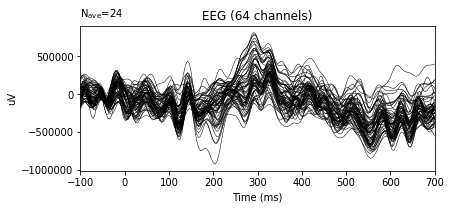

In [958]:
for char in chars:
    events = char_events[char]
    if char == character:
        print(char)
        epochs[events].average().plot()
    plt.show()

Get FFT decomposition of the signal for the certain character

In [877]:
events = char_events['G']

In [853]:
signal = epochs[events].average().data

In [854]:
signal_fft = np.abs(np.fft.fft(signal, axis=1))

In [855]:
signal_fft[:, :signal_fft.shape[-1] // 2].shape

(64, 96)

In [856]:
import seaborn as sns

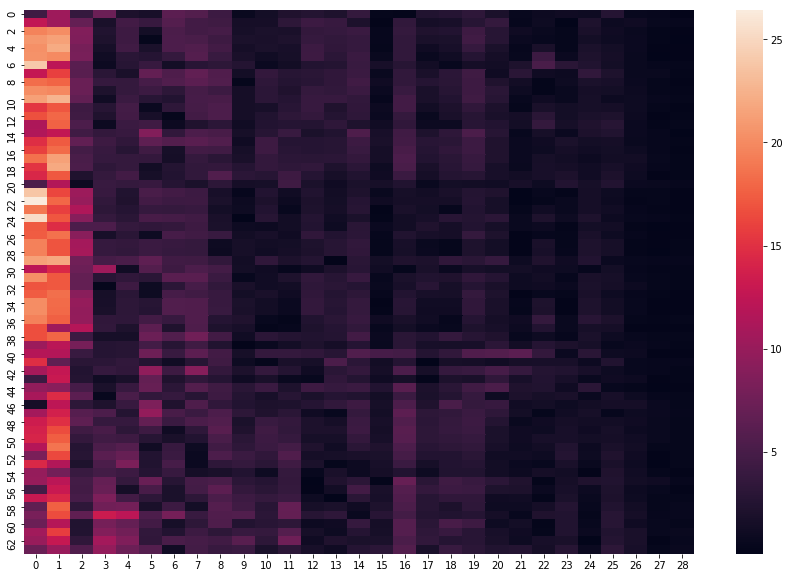

In [857]:
sns.heatmap(signal_fft[:, 1:30])

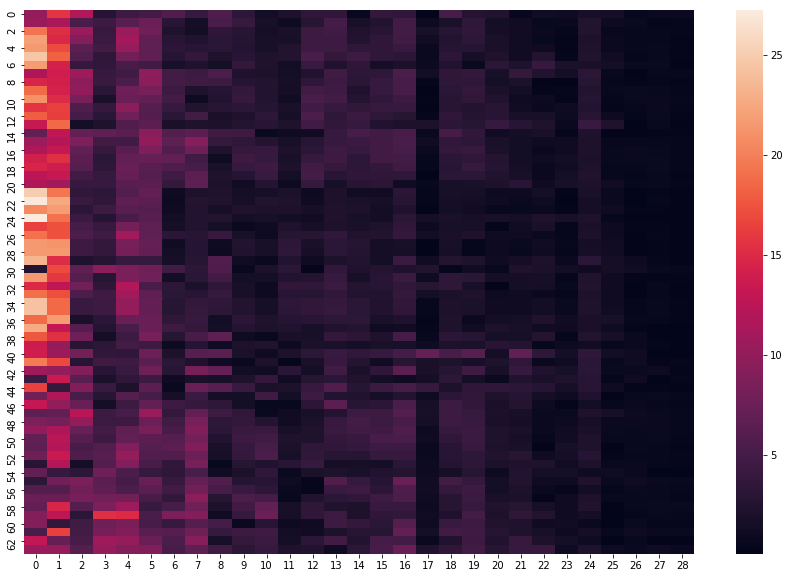

In [851]:
sns.heatmap(signal_fft[:, 1:30])

In [795]:
signal.shape

(64, 193)

In [786]:
events = char_events[character] 
extract_features('s1', epochs[events], sliding_window_size=12)

Averaging by 24 attemps


[[396.875, 0.1901147757265359, 0.20684920720003508, 12.5, 12.5, 0, 's1'],
 [418.75, 0.2331221548863106, 0.5227947693939884, 12.5, 34.375, 1, 's1'],
 [396.875, 0.31329240919167134, 0.18193203040750408, 34.375, 12.5, 2, 's1'],
 [396.875, 0.6740905846789128, 0.1263286107652129, 96.875, 12.5, 3, 's1'],
 [396.875, 0.7611099966475248, 0.18677775718439238, 96.875, 12.5, 4, 's1'],
 [393.75, 0.4658931455482949, 0.20784941044862598, 43.75, 15.625, 5, 's1'],
 [390.625, 0.253728230178136, 0.22982031853692125, 15.625, 15.625, 6, 's1'],
 [418.75, 0.2769373707628518, 0.3576898078776644, 12.5, 15.625, 7, 's1'],
 [418.75, 0.18431649394526717, 0.4413901781792146, 12.5, 37.5, 8, 's1'],
 [418.75, 0.13771216693948843, 0.44865661229602105, 12.5, 37.5, 9, 's1'],
 [418.75, 0.13367607003713164, 0.5059916157985636, 12.5, 37.5, 10, 's1'],
 [418.75, 0.15488115909125988, 0.5446359234981913, 12.5, 34.375, 11, 's1'],
 [393.75, 0.22985220712882184, 0.2072605813864882, 15.625, 12.5, 12, 's1'],
 [393.75, 0.203985239513

In [787]:
char = 'M'
events = char_events[char] 
extract_features('s1', epochs[events], sliding_window_size=12)

Averaging by 22 attemps


[[200.0, 0.35952809653946344, 0.44871691317814744, 18.75, 31.25, 0, 's1'],
 [415.625, 0.22152170492951126, 0.47756336888634965, 53.125, 40.625, 1, 's1'],
 [421.875, 0.14066251835076768, 0.6123264474540089, 12.5, 37.5, 2, 's1'],
 [421.875, 0.13187804081147853, 0.6302738674843023, 15.625, 37.5, 3, 's1'],
 [421.875, 0.15876770039166993, 0.6522736924461163, 15.625, 37.5, 4, 's1'],
 [421.875, 0.21397656127168863, 0.5993915541504028, 12.5, 37.5, 5, 's1'],
 [393.75, 0.48771171361031007, 0.32429886956389137, 37.5, 12.5, 6, 's1'],
 [200.0, 0.49234635889075196, 0.4880541757133985, 15.625, 25.0, 7, 's1'],
 [396.875, 0.2261863708704608, 0.11008441040843936, 21.875, 12.5, 8, 's1'],
 [421.875, 0.11668055225976748, 0.49891857364001, 12.5, 34.375, 9, 's1'],
 [421.875, 0.16505570327409627, 0.6109870664040863, 15.625, 37.5, 10, 's1'],
 [421.875, 0.19843257235412934, 0.5659346941331733, 15.625, 37.5, 11, 's1'],
 [421.875, 0.27254816233157303, 0.5383395336300708, 12.5, 37.5, 12, 's1'],
 [393.75, 0.4833907

In [334]:
from peaks import extract_features